In [17]:
!date -I

2023-03-10


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from tvb.simulator.lab import *

/home/izaak/local_repos/nostromo/tvb-adex-cleanup/tvb_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [4]:
from adex_cleanup import configure_sim, plot_normal

In [5]:
from tvb.simulator.lab import *

These are the parameters:

```
# %load -n 'cfgs/divolo2019.toml'
[parameters]
# all these shall become numpy arrays when loaded
C_m = 200.0
E_L_e = -65.0
E_L_i = -65.0
E_e = 0.0
E_i = -80.0
K_ext_e = 400
K_ext_i = 100 # this is weirdly set to 0 by default as the external drive is excitatory
N_tot = 10000
P_e = [-4.98e-02 , 5.06e-03 , -2.5e-02 , 1.4e-03 , -4.1e-04 , 1.05e-02 , -3.6e-02 , 7.4e-03 , 1.2e-03 , -4.07e-02]
P_i = [ -5.14e-02 , 4.0e-03 , -8.3e-03 , 2.0e-04 , -5.0e-04 , 1.4e-03 , -1.46e-02 , 4.5e-03 , 2.8e-03 , -1.53e-02 ]
Q_e = 1.5
Q_i = 5.0
T = 5.0
a_e = 4.0
a_i = 0.0
b_e = 60.0
b_i = 0.0
external_input_ex_ex = 2.5e-3#0.315e-3
external_input_ex_in = 0.000
external_input_in_ex = 2.5e-3#0.315e-3
external_input_in_in = 0.000
g = 0.2
g_L = 10.0
p_connect_e = 0.05
p_connect_i = 0.05
tau_OU = 5.0
tau_e = 5.0
tau_i = 5.0
tau_w_e = 500.0
tau_w_i = 1.0
weight_noise = 1e-4

[attributes]
# these are approached on a case-by-case basis
stvar = [7] 
variables_of_interest=['E', 'I', 'C_ee', 'C_ei', 'C_ii', 'W_e', 'W_i', 'ou_drift']
state_variable_range.E = [0.0, 0.0] 
state_variable_range.I =  [0.0, 0.0] 
state_variable_range.C_ee = [0.0, 0.0] 
state_variable_range.C_ei = [0.0, 0.0] 
state_variable_range.C_ii = [0.0, 0.0] 
state_variable_range.W_e = [0.0, 0.0] 
state_variable_range.W_i = [0.0, 0.0] 
state_variable_range.ou_drift = [0.0, 0.0]

```

In [8]:
sim = configure_sim('cfgs/divolo2019.toml', with_noise=False)
(out_t, out_d),  = sim.configure().run(simulation_length=5000)

WARNING  File 'hemispheres' not found in ZIP.
WARNING  random_state supplied for non-stochastic integration


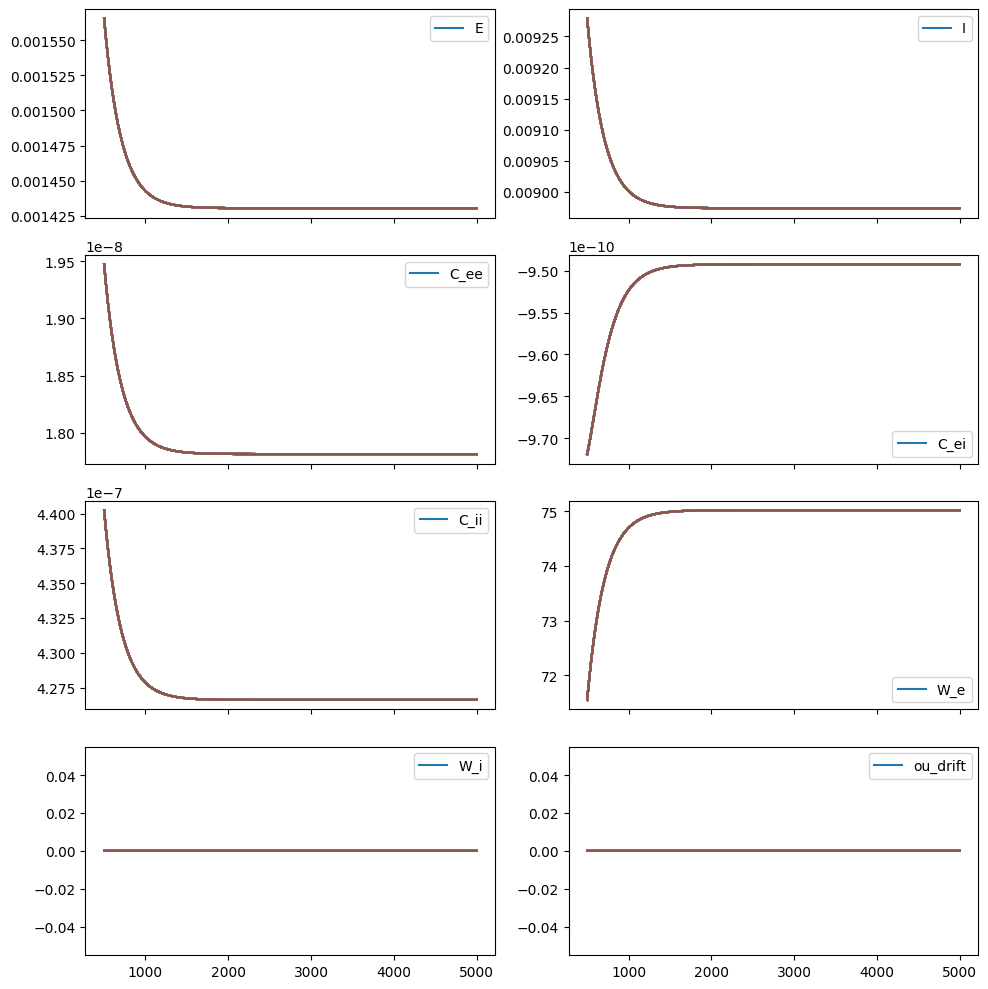

In [9]:
t0=500
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharex=True)
for i,(var, ax) in enumerate(zip(sim.model.state_variables, axs.flatten())):
    ax.plot(out_t[t0:], out_d[t0:,i,:,0])
    ax.legend(labels=[var])
fig.tight_layout()

In [10]:
sim.model.state_variables

['E', 'I', 'C_ee', 'C_ei', 'C_ii', 'W_e', 'W_i', 'ou_drift']

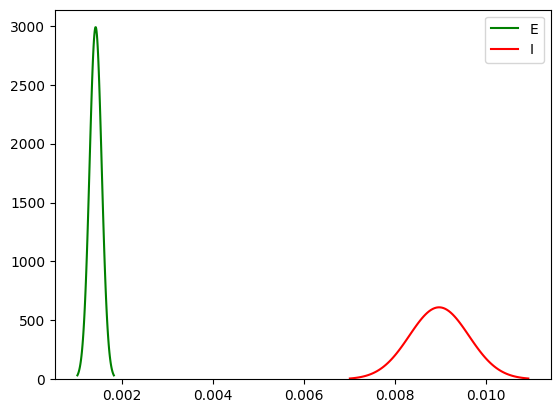

In [11]:
E = out_d[-1,0,0,0]
I = out_d[-1,1,0,0]
C_ee = out_d[-1,2,0,0]
C_ii = out_d[-1,4,0,0]

fig, ax = plt.subplots()
plot_normal(E, np.sqrt(C_ee),ax, c='g', label='E')
plot_normal(I, np.sqrt(C_ii),ax, c='r', label='I')
ax.set_ylim(bottom=0)
ax.legend()

Ok, this looks like success. Let's sweep over `b_e`

In [12]:
sim.connectivity.number_of_regions

76

In [13]:
sim = configure_sim('cfgs/divolo2019.toml', with_noise=False)
sim.model.b_e = np.linspace(0, 150, 76)[:,np.newaxis]

(out_t, out_d),  = sim.configure().run(simulation_length=5000)

WARNING  File 'hemispheres' not found in ZIP.
WARNING  random_state supplied for non-stochastic integration


In [14]:
out_d.shape

(5000, 8, 76, 1)

In [15]:
E = out_d[-1,0,:,0]
I = out_d[-1,1,:,0]
C_ee = out_d[-1,2,:,0]
C_ii = out_d[-1,4,:,0]

(0.0, 150.0)

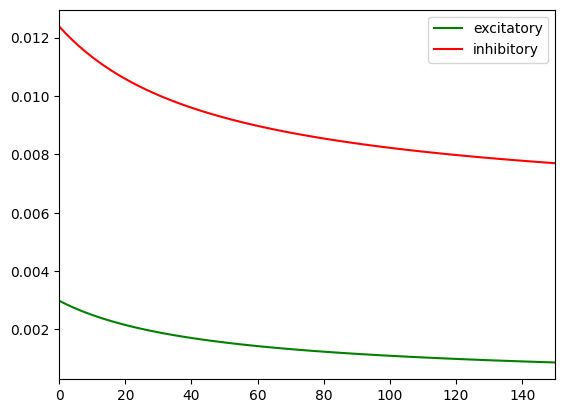

In [16]:
fig, ax = plt.subplots()
ax.plot(sim.model.b_e,E, c='g', label='excitatory')
ax.plot(sim.model.b_e,I, c='r', label='inhibitory')
ax.legend()
ax.set_xlim(0,150)

This was without the fix of Gus.